# GitHub API v3 - Uso de labels

> Para los siguientes ejercicios usaremos el repositorio del curso **Programación Avanzada** de la Pontificia Universidad Católica de Chile para el segundo semestre del 2015. Ve el repo [aqui](https://github.com/IIC2233-2015-2/syllabus).

Una herramienta interesante para saber el comportamiento de un repositorio es buscar la cantidad de issues (abiertas + cerradas) para cada label disponible:

In [1]:
# Primero tenemos que importar las librerias que usaremos para recopilar datos
import base64
import json
import requests

# Si queremos imprimir los json de respuesta 
# de una forma mas agradable a la vista podemos usar
def print_pretty(jsonstring, indent=4, sort_keys=False):
    print(json.dumps(jsonstring, indent=indent, sort_keys=sort_keys))
    
# Importamos nuestras credenciales
with open("credentials") as f:
    credentials = tuple(f.read().splitlines())
    
# Constantes que usaremos
OWNER = "IIC2233-2016-1"
REPO = "syllabus"

Antes que todo, debemos preguntarnos: ¿a qué queremos acceso? Así podemos definir los scopes que necesitamos en nuestro token y también podremos facilitar nuestro flujo de trabajo

* Obtener issues
* Obtener labels
* Guardar cantidades para cada label
* Graficar (opcional)

Para hacer esto usaremos la sección de la [API de GitHub para issues](https://developer.github.com/v3/issues/#list-issues-for-a-repository). Para obtener las issues de un repositorio...

> GET /repos/:owner/:repo/issues



In [2]:
url = "https://api.github.com/repos/{}/{}/issues".format(OWNER, REPO)
params = {
    "state": "closed",
    "sort": "created",
    "direction": "asc",
    "page": 1
}
req = requests.get(url, params=params, auth=credentials)

print(req.status_code)
# Para obtener el json asociado: req.json()
# Pero queremos imprimirlo de una manera mas legible
for issue in req.json():
    print(issue["number"], issue["title"])

200
1 Material 1ra clase - modelacion
2 Duda python
3 materia OOP
4 Problema alumno sin repositorio
5 Duda acerca de super()
6 Ayuda para Setup de git
7 Personalizando Atom
8 Unas dudas sobre Herencia
9 seccion 2
10 Protocolos especiales del curso
11 material edd
12 aclaracion arista nodo
13 Ponderación entre MidTerm y FinalTest
14 Problema intentando hacer la barra vertical
15 [No es del Curso][Un poco de ayuda con PYGAME]
16 Actividad 3
17 Uso libreria JSON en Tarea01 
18 Uso del módulo OS de Python
19 Asumir input correctos
20 [TAREA 01][Modulo Time]
21 Actividad 2 commit a revisar
22 [Tarea01] Productos-usuarios diccionarios
23 Consulta acerca de personas.txt
24 Distribucion de puntaje T01
25 Falta de nombres en productos.txt Tarea 1
26 Duda sobre método en la solución de la AC4 2015-1
27 Pregunta sobre los usuarios baneados
28 Error en archivo personas.txt
29 confusion enunciado en subasta
30 [TAREA 01][¿Correos electrónicos válidos?]


Como podemos notar, es posible que tengamos más de una página de issues, por lo que tendremos que acceder al *header* y obtener la url a la siguiente página, repitiendo la operación hasta llegar a la última. Para facilitar esto, podemos agregar el parametro *page* a la url indicando el número de la página que queremos. ¿Cómo sabremos cuándo detenernos? Cuando en el *header*, en *Link*, no exista una url a la siguiente página (`"next"`) 

In [3]:
# Si esta fuese la ultima pagina no existiria `rel="next"`
print(dict(req.headers)["Link"])
print("¿Es la ultima pagina? {}".format("No" if 'rel="next"' in dict(req.headers)["Link"] else "Si"))

<https://api.github.com/repositories/48136135/issues?direction=asc&page=2&sort=created&state=closed>; rel="next", <https://api.github.com/repositories/48136135/issues?direction=asc&page=3&sort=created&state=closed>; rel="last"
¿Es la ultima pagina? No


Guardemos la información que nos interesa en objetos de una clase `Issue`, extraeremos los nombres de las labels con la funcion `labels` y guardaremos a estos objetos en una lista llamada `ISSUES_LIST`

In [4]:
class Issue:
    
    def __init__(self, number, title, labels):
        self.number = number
        self.title = title
        self.labels = labels
        
def labels(labels_json):
    return [label_item["name"] for label_item in labels_json]

ISSUES_LIST = list()

Pediremos todas las issues e iremos guardando los objetos correspondientes:

In [5]:
url = "https://api.github.com/repos/{}/{}/issues".format(OWNER, REPO)
params = {
    "state": "closed",
    "sort": "created",
    "direction": "asc",
    "page": 1
}

# Primera pagina
req = requests.get(url, params=params, auth=credentials)
for issue in req.json():
    ISSUES_LIST.append(Issue(issue["number"], issue["title"], labels(issue["labels"])))

# Paginas siguientes
while 'rel="next"' in dict(req.headers)["Link"]:
    print("Page: {} ready".format(params["page"]))
    params["page"] += 1
    req = requests.get(url, params=params, auth=credentials)
    for issue in req.json():
        ISSUES_LIST.append(Issue(issue["number"], issue["title"], labels(issue["labels"])))
print("Tenemos {} issues en la lista".format(len(ISSUES_LIST)))

Page: 1 ready
Page: 2 ready
Tenemos 76 issues en la lista


Ya tenemos nuestra lista de issues. Ahora, veamos cuales son las labels que se han usado

In [6]:
LABELS = list(label for issue in ISSUES_LIST for label in issue.labels)
print(set(LABELS))

{'URGEN3', 'Actividades', 'Materia', 'Duplicada', 'Inválida', 'Administrativa', 'Tengo un error', 'Sé crear labels', 'Código', 'IMPORTANTE', 'Setup', 'Otros', 'Tarea 1', 'Material'}


Empecemos con los gráficos. Para esto usaremos `matplotlib`:

In [7]:
%matplotlib inline

Vamos a desplegar un grafo donde cada nodo es un label y cada arista representa las uniones de labels (cuando una issue tiene más de un label). El tamaño de los nodos dependerá de la cantidad de issues etiquetadas con aquel label y el grosor de las aristas dependerá de la cantidad de issues en la que ambos labels estuvieron. Si en alguna issue hubo mas de dos etiquetas, consideraremos los pares de labels y no un conjunto.

Para esto, necesitamos:

In [8]:
# Cantidad de issues por label

LABEL_ISSUES = {label: LABELS.count(label) for label in LABELS}

# Imprimiendo de mayor a menor numero de issues...
print("Top {}".format(min(5, len(LABEL_ISSUES))))
for v, k in sorted(((v,k) for k,v in LABEL_ISSUES.items()), reverse=True)[:min(5, len(LABEL_ISSUES))]:
    print("{}: {}".format(k, v))

Top 5
Tarea 1: 42
Código: 13
Setup: 7
Tengo un error: 4
Actividades: 4


In [9]:
# Todos los pares de labels

from itertools import combinations

LABEL_PAIRS = dict()
PAIRS = list()
for issue in ISSUES_LIST:
    combs = combinations(issue.labels, 2)
    for pair in combs:
        k = "{} + {}".format(*pair)
        if k not in LABEL_PAIRS:
            LABEL_PAIRS[k] = 0
            PAIRS.append(pair)
        LABEL_PAIRS[k] += 1
        
# Imprimiendo de mayor a menor numero de issues
print("Top {}".format(min(5, len(LABEL_PAIRS))))
for v, k in sorted(((v,k) for k,v in LABEL_PAIRS.items()), reverse=True)[:min(5, len(LABEL_PAIRS))]:
    print("{}: {}".format(k, v))

Top 5
Tarea 1 + Tengo un error: 2
Código + Tengo un error: 2
Código + Materia: 2
Actividades + Materia: 2
Actividades + Código: 2


Para la siguiente sección usaremos `nextworkx` para graficar la red de nodos:

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

import matplotlib.pylab as plt
import networkx as nx

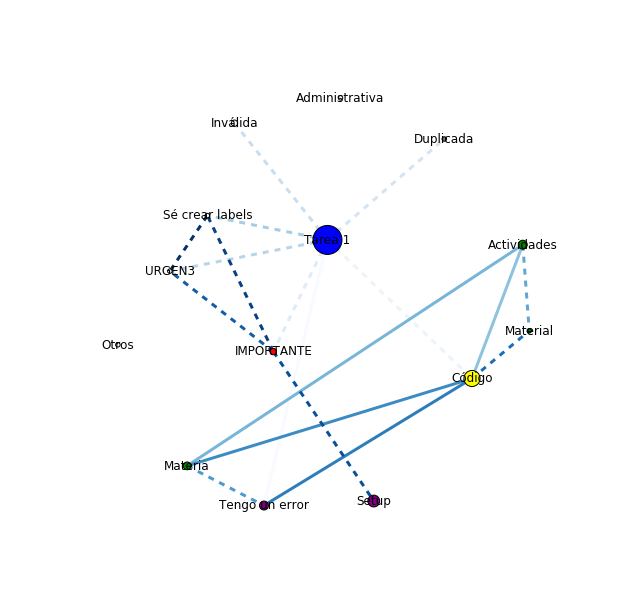

In [13]:
# Crear grafo
G = nx.Graph()

# Max peso
mp = LABEL_PAIRS[max(LABEL_PAIRS, key=LABEL_PAIRS.get)]

# Crear nodos
G.add_nodes_from(LABEL_ISSUES.keys())

# Crear arcos
for o_pair in LABEL_PAIRS.keys():
    pair = o_pair.split(' + ')
    G.add_edge(*pair, 
               weight=mp-LABEL_PAIRS[o_pair],
               width=mp-LABEL_PAIRS[o_pair])
    
# Asignar color
n_colors = list()
for node in G.nodes():
    color = 'white'
    if 'Tarea' in node:
        color = 'blue'
    elif node in ['Tengo un error', 'Setup']:
        color = 'purple'
    elif node in ['Actividades', 'Ayudantía', 'Ayudantia', 'Interrogación', 'Interrogacion', 'Materia', 'Material']:
        color = 'green'
    elif node in ['Código', 'Codigo', 'Git']:
        color = 'yellow'
    elif node in ['Duplicada', 'Invalida']:
        color = 'grey'
    elif node in ['IMPORTANTE']:
        color = 'red'
    n_colors.append(color)
    
# Asignar tamaños de nodos
sizes = list()
for node in G.nodes():
    sizes.append(20 * LABEL_ISSUES[node])
    
# Asignar grosores de aarcos
average = round(sum(LABEL_PAIRS.values()) / (0.75 * len(LABEL_PAIRS)))
styles = list()
widths = list()
for edge in G.edges():
    k = "{} + {}".format(edge[0], edge[1])
    if k not in LABEL_PAIRS:
        k = "{} + {}".format(edge[1], edge[0])
    if LABEL_PAIRS[k] < average:
        styles.append('dashed')
        widths.append(LABEL_PAIRS[k] + average)
    else:
        styles.append('solid')
        widths.append(LABEL_PAIRS[k] + 1)
    
# Colores de arcos
e_colors = list(i + 10 for i in range(len(G.edges())))
    
# Desplegar graficos
nx.draw(G,        
        edge_color=e_colors,
        edge_cmap=plt.cm.Blues,
        node_color=n_colors,
        node_size=sizes,
        style=styles,
        width=widths,
        with_labels=True)

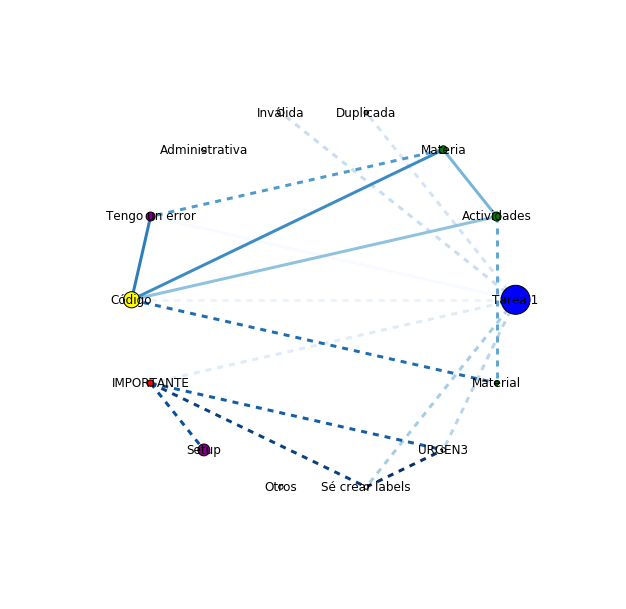

In [14]:
nx.draw_circular(G,        
        edge_color=e_colors,
        edge_cmap=plt.cm.Blues,
        node_color=n_colors,
        node_size=sizes,
        style=styles,
        width=widths,
        with_labels=True)